##### Minh Anh, Anjiu Shi, Angel Chen, Angelica Pen
##### DSCI_V 100 008
## Project Final Report

### Introduction

##### Background Information:

For our report, we will be using data collected by a research group in Computer Science at UBC, led by Frank Wood. Their project is based on the recorded actions of players in a MineCraft server they have set up. Their aim is to use the recorded data to understand where to focus their recruitment efforts (the players to attract) and make sure they have enough resources (e.g., software licenses, server hardware). They have provided three broad questions they would like to answer, which is where we contribute by picking one of these questions and doing an in depth data analysis of it.

##### Our Specific Question

Which factors contribute the most to predict a player’s potential engagement in the game?

##### Definitions:
**Factors** : Player's characteristics/demographics ultimately narrowed down to experience and subscription status.  <br>
**Potential engagement**: The number of total hours played or the potential amount of hours they will play based on their characteristics. <br>

##### Why we chose to explore this question:
We choose this question because if we are able to tell which player characteristics are key to predict their number of hours in the game, this prediction model would be very useful for game developers. Developers can improve game design and player experience, and personalize in-game recommendations (for example: personalizing by increasing in-game purchases ads for players who have potential to spend more time on the game).

Loading packages and setting a seed for the entire notebook:

In [1]:
# Please run this cell first.
library(repr)
library(tidyverse)
library(tidymodels)
library(themis)
options(scipen = 999, repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### We would like to answer the general research question: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

### For that, we will only be using the players.csv dataset.

In [2]:
# Loading players.csv and sessions.csv and tidying them. We will only be using players.csv for analysis,
# but sessions.csv is included for us to explain our method later.

# players.csv
players <- read_csv("https://raw.githubusercontent.com/achen45-png/toy_ds_project/refs/heads/main/data/players.csv",
                    show_col_types = FALSE) |>
    mutate(
        experience = as_factor(experience), # Correcting the data types.
        gender = as_factor(gender),
        Age = as.integer(Age),
        subscribe = as_factor(subscribe) # Logical is indeed the most appropriate data type, but I'm changing it to
    ) |>                                 # factor because step_dummy() in a later step only works with factors.
    na.omit()
players

# sessions.csv
sessions <- read_csv("https://raw.githubusercontent.com/achen45-png/toy_ds_project/refs/heads/main/data/sessions.csv",
                     show_col_types = FALSE) |>
    mutate(
        start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M", tz = "GMT"),
        end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M", tz = "GMT")    
    ) |>
    na.omit()
# Changing the date and times from character to datetime data in sessions.csv is kind of unnecessary given that
# we are not using this dataset for our analysis. However, I included it anyway because I want to show a point.
# See next cell.

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


### The reason we are not using sessions.csv is because it is not a good metric for player data contribution. See the code below.

hashedEmail,num_sessions
<chr>,<int>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,219
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,159
⋮,⋮
fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,1
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1


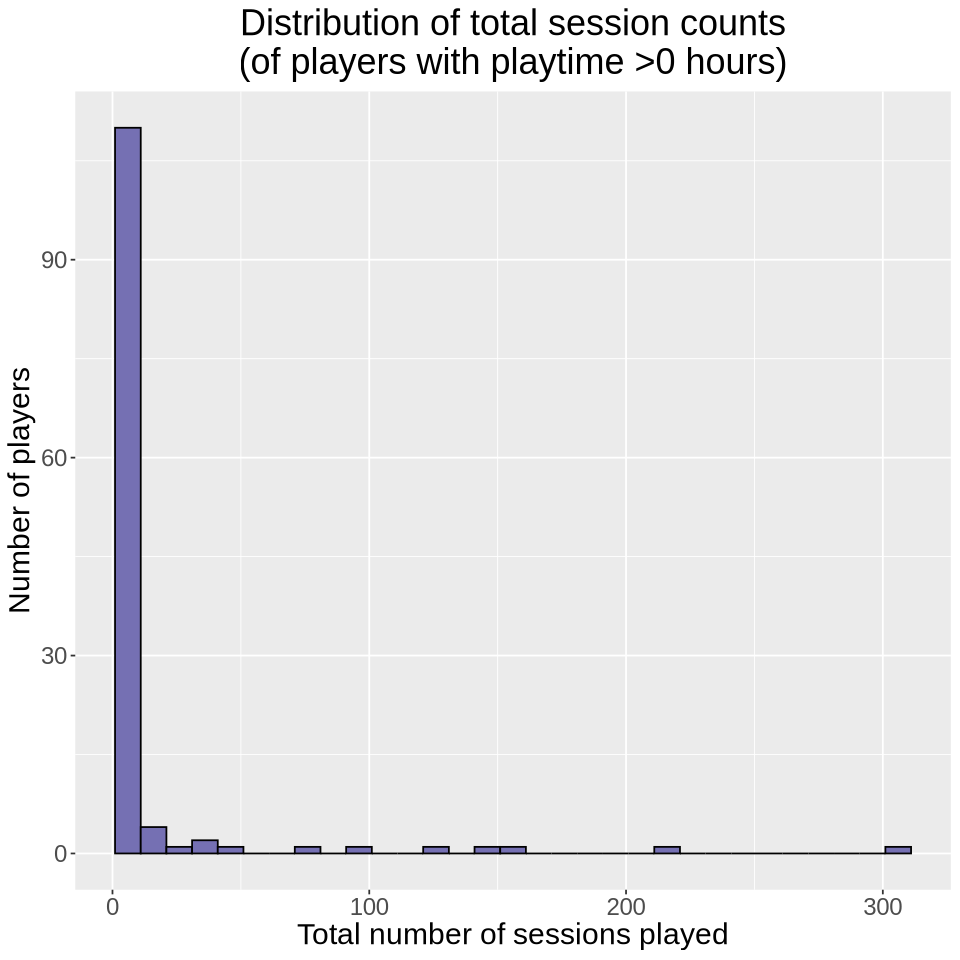

In [3]:
sessions_unique_hash <- sessions |>
    group_by(hashedEmail) |>
    summarize(num_sessions = n()) |>
    arrange(desc(num_sessions))
sessions_unique_hash

options(repr.plot.width = 8, repr.plot.height = 8)
sessions_count <- sessions_unique_hash |>
    ggplot(aes(num_sessions)) +
        geom_histogram(colour = "black", fill = "#7570b3ff", binwidth = 10, boundary = 1) +
        labs(x = "Total number of sessions played", y = "Number of players",
             title = "Distribution of total session counts\n(of players with playtime >0 hours)") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5))
sessions_count

### Each observation in sessions.csv is equivalent to one instance of a player login onto PLAICraft.ai to play Minecraft for an uninterrupted duration. Certain players have high session counts. However, as we can see (below), the duration of these sessions are varied (e.g. 6 minutes and whatnot -- just show the code for that). Therefore, we've decided that played_hours from players.csv is sufficient enough as a metric for player data contribution.

In [4]:
sessions_duration <- sessions |>
    mutate(time_diff = end_time - start_time) |>
    group_by(hashedEmail) |>
    summarize(mean_sesh_duration = mean(time_diff),
              median_sesh_duration = median(time_diff)) |>
    merge(sessions_unique_hash) |>
    arrange(desc(num_sessions))
head(sessions_duration, n = 6)
tail(sessions_duration, n = 6)

,hashedEmail,mean_sesh_duration,median_sesh_duration,num_sessions
,<chr>,<drtn>,<drtn>,<int>
1,fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15.46774 mins,7 mins,310
2,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,66.99087 mins,63 mins,219
3,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,62.55975 mins,49 mins,159
4,ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,80.45578 mins,62 mins,147
5,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,29.79231 mins,22 mins,130
6,b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,150.34043 mins,143 mins,94


,hashedEmail,mean_sesh_duration,median_sesh_duration,num_sessions
,<chr>,<drtn>,<drtn>,<int>
120,f707d141be44b2bf963eb171dbd14599059b4dda09aa002ba95ead4fa67273a7,8 mins,8 mins,1
121,f7875ae87a61632030d5c4029ee8cf081be7047b2b4a9c04ab5a706f59786197,19 mins,19 mins,1
122,fc0224c81384770e93ca717f32713960144bf0b52ff67639433a5c06a653a882,16 mins,16 mins,1
123,fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,80 mins,80 mins,1
124,fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,9 mins,9 mins,1
125,fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,72 mins,72 mins,1


### Anyway so we know that sessions.csv is not useful to answering our research Q so it will be omitted. Player data contribution = played_hours. MOVING ON, we're gonna do best subset selection:

In [82]:
set.seed(42) # NOBODY TOUCH THIS PLEASE.

# I decided to use best subset selection over forward selection because we don't have that many potential predictor variables
# anyway (only 4). Since we don't have any computational costs or limits for using best subset selection, there's no reason not to,
# especially when forward selection is not as comprehensive.

# For convenience, columns we don't need for analysis are removed.
players_removed <- players |>
    select(-hashedEmail, -name)

# Splitting the data.
players_split <- initial_split(players_removed, prop = 0.75, strata = played_hours) # Standard 75/25 split for training/testing.
players_training <- training(players_split)
players_testing <- testing(players_split)

# knn tuning model that will be used for every candidate model.
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

In [83]:
# A separate code cell for all the recipes.
# Recipes for each possible combination of predictor variables (15 total). Our response variable is played_hours.

# 1 predictor
# Recipe 1: experience
recipe_1 <- recipe(played_hours ~ experience, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |> # Scale and center are not necessary when there's only 1 predictor.
    step_center(all_predictors())   # They're there because I copy-pasted the recipes. :D
# Recipe 2: subscribe
recipe_2 <- recipe(played_hours ~ subscribe, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 3: gender
recipe_3 <- recipe(played_hours ~ gender, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 4: Age
recipe_4 <- recipe(played_hours ~ Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 2 predictors
# Recipe 5: experience + subscribe
recipe_5 <- recipe(played_hours ~ experience + subscribe, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 6: experience + gender
recipe_6 <- recipe(played_hours ~ experience + gender, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 7: experience + Age
recipe_7 <- recipe(played_hours ~ experience + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 8: subscribe + gender
recipe_8 <- recipe(played_hours ~ subscribe + gender, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 9: subscribe + Age
recipe_9 <- recipe(played_hours ~ subscribe + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 10: gender + Age
recipe_10 <- recipe(played_hours ~ gender + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 3 predictors
# Recipe 11: experience + subscribe + gender
recipe_11 <- recipe(played_hours ~ experience + subscribe + gender, data = players_training) |>
     step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 12: experience + subscribe + Age
recipe_12 <- recipe(played_hours ~ experience + subscribe + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 13: experience + gender + Age
recipe_13 <- recipe(played_hours ~ experience + gender + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 14: subscribe + gender + Age
recipe_14 <- recipe(played_hours ~ subscribe + gender + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 4 predictors
# Recipe 15: ALL 4 variables, experience + subscribe + gender + Age
recipe_15 <- recipe(played_hours ~ ., data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# I tried to make a recipe_printer, but shit was impossible so we're stuck with this tedious code. :(

In [86]:
set.seed(84) # NOBODY TOUCH THIS PLEASE.

# Running 10-fold cross-validation for all candidate models.
vfold <- vfold_cv(players_training, v = 10, strata = played_hours)

# Range of k values.
kvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# A convenient function that spits out the best k and lowest rmse (mean) of any candidate model (recipe).
workflow_printer <- function(recipe, model) {
    workflow() |>
    add_recipe(recipe) |>
    add_model(model) |>
    tune_grid(resamples = vfold, grid = kvals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)
}

workflow_1 <- workflow_printer(recipe_1, knn_tune)
workflow_2 <- workflow_printer(recipe_2, knn_tune)
workflow_3 <- workflow_printer(recipe_3, knn_tune)
workflow_4 <- workflow_printer(recipe_4, knn_tune)
workflow_5 <- workflow_printer(recipe_5, knn_tune)
workflow_6 <- workflow_printer(recipe_6, knn_tune)
workflow_7 <- workflow_printer(recipe_7, knn_tune)
workflow_8 <- workflow_printer(recipe_8, knn_tune)
workflow_9 <- workflow_printer(recipe_9, knn_tune)
workflow_10 <- workflow_printer(recipe_10, knn_tune)
workflow_11 <- workflow_printer(recipe_11, knn_tune)
workflow_12 <- workflow_printer(recipe_12, knn_tune)
workflow_13 <- workflow_printer(recipe_13, knn_tune)
workflow_14 <- workflow_printer(recipe_14, knn_tune)
workflow_15 <- workflow_printer(recipe_15, knn_tune)

# Combining each candidate model's best k and lowest rmse for comparison.
best_subset <- rbind(workflow_1, workflow_2, workflow_3, workflow_4, workflow_5,
                     workflow_6, workflow_7, workflow_8, workflow_9, workflow_10,
                     workflow_11, workflow_12, workflow_13, workflow_14, workflow_15) |>
    mutate(recipe_workflow_n = c(1:15)) |>
    arrange(mean)
head(best_subset, n = 6)

→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x1



→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x7

There were issues with some computations   A: x10



→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x2

There were issues with some computations   A: x2



→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a 

neighbors,.metric,.estimator,mean,n,std_err,.config,recipe_workflow_n
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<int>
10,rmse,standard,23.46515,10,7.282559,Preprocessor1_Model10,5
1,rmse,standard,23.91264,10,7.579489,Preprocessor1_Model01,2
1,rmse,standard,23.91396,10,7.581235,Preprocessor1_Model01,3
1,rmse,standard,23.91665,10,7.579021,Preprocessor1_Model01,1
1,rmse,standard,23.92039,10,7.581346,Preprocessor1_Model01,8
10,rmse,standard,25.09563,10,7.120350,Preprocessor1_Model10,9


### OKAY!!! (finally) Best model uses predictors experience and subscribe (recipe 5) with k = 10. NOW WE WILL BUILD OUR FINAL MODEL AND RUN IT THROUGH THE TESTING SET!!!

In [108]:
# Building the "official" knn regression model using recipe 5 and k = 10.
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
    set_engine("kknn") |>
    set_mode("regression")

# Training the model using the entirety of the training set.
players_knn_fit <- workflow() |>
    add_recipe(recipe_5) |>
    add_model(knn_spec_final) |>
    fit(data = players_training)

# Using the fully trained model on the testing set.
players_pred <- players_knn_fit |>
    predict(players_testing) |>
    bind_cols(players_testing)
players_pred

# Extracting the RMSPE from using our model on the testing set.
players_knn_rmspe <- players_pred |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == "rmse")
players_knn_rmspe

.pred,experience,subscribe,played_hours,gender,Age
<dbl>,<fct>,<fct>,<dbl>,<fct>,<int>
0.72,Veteran,FALSE,0.0,Male,17
0.03,Amateur,TRUE,0.7,Female,21
0.03,Veteran,TRUE,0.0,Female,22
⋮,⋮,⋮,⋮,⋮,⋮
0.31,Pro,FALSE,0.2,Male,17
0.46,Amateur,FALSE,0.0,Male,17
0.72,Veteran,FALSE,0.3,Male,22


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,12.22768


# Y'ALL CAN IGNORE THE CODE BELOW IF NOT NECESSARY - this stuff doesn't need to be included unless you want to talk more about the data

### Potential confounding variable: Is subscription status influenced by play hours? Such as players who play more will only subscribe BECAUSE they play more. It's only a correlation NOT CAUSATION!!

In [9]:
subscribe_zero_hours <- players |>
    filter(played_hours == 0) |>
    group_by(subscribe) |>
    summarize(n = n())
subscribe_zero_hours

subscribe,n
<fct>,<int>
FALSE,27
TRUE,58


### Even players with 0 hours of playtime subscribe to the newsletter, so we should be pretty reassured that players don't only subscribe to the newsletter if they play.

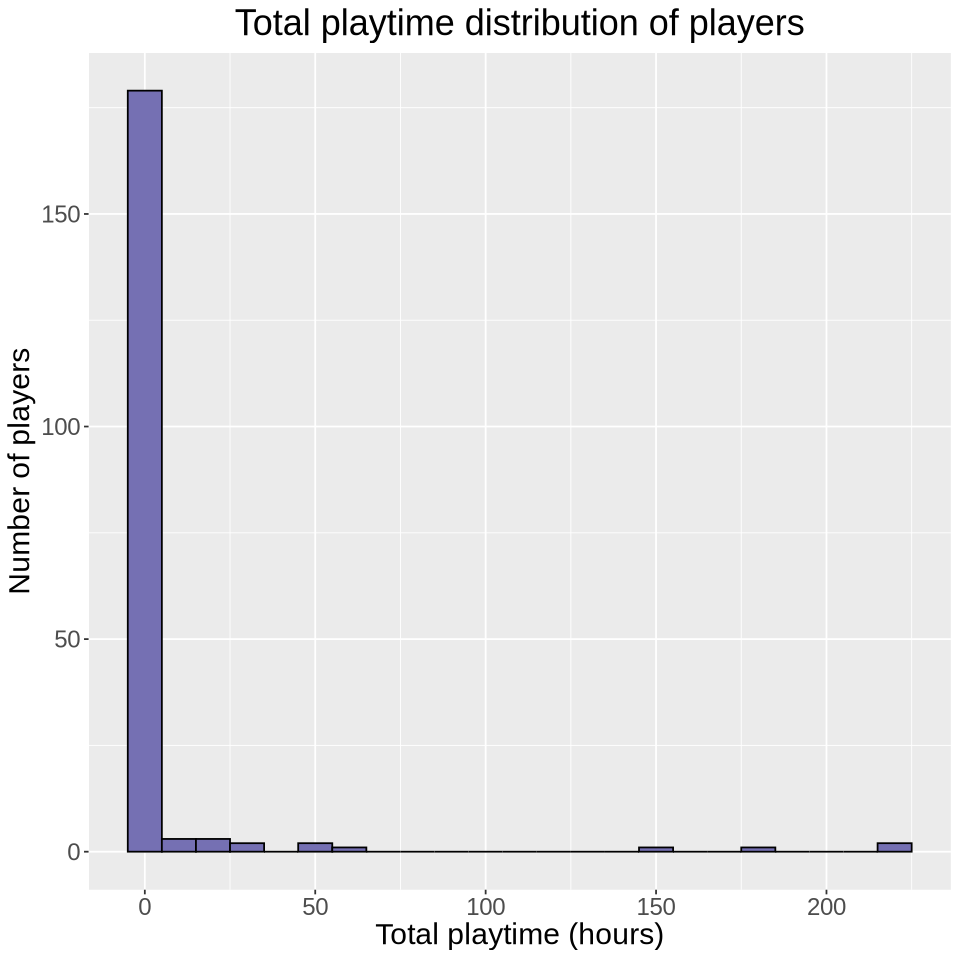

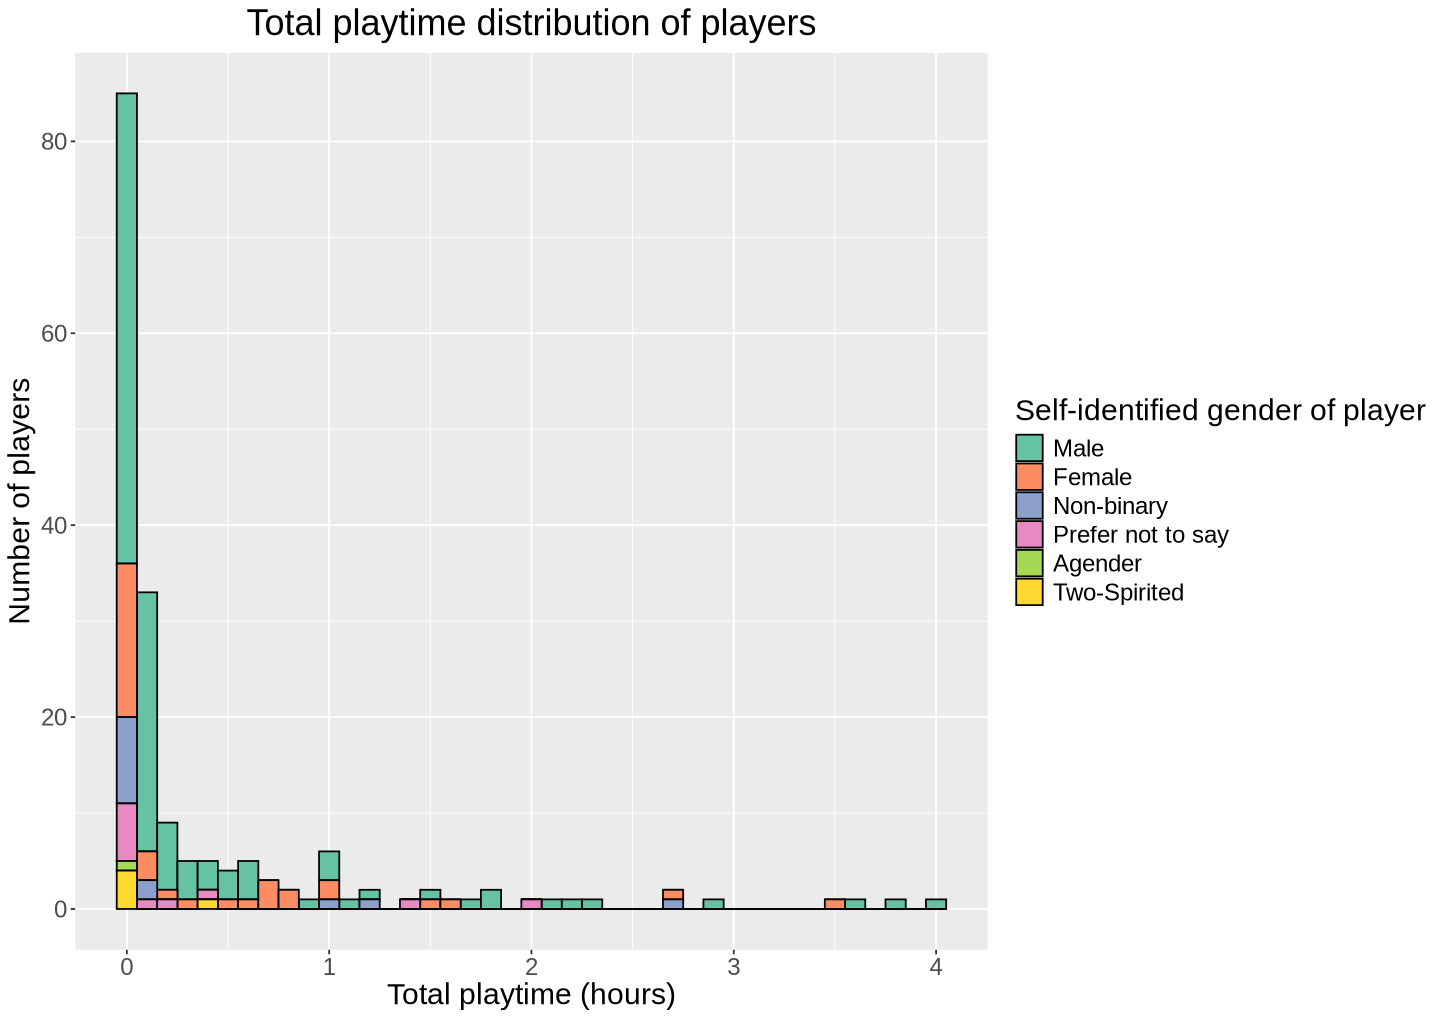

In [11]:
options(repr.plot.width = 8, repr.plot.height = 8)
played_hours_hist <- players |>
    ggplot(aes(played_hours)) +
        geom_histogram(colour = "black", fill = "#7570b3ff", binwidth = 10) +
        labs(x = "Total playtime (hours)", y = "Number of players",
             title = "Total playtime distribution of players") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5))
played_hours_hist

options(repr.plot.width = 12, repr.plot.height = 8.5)
played_hours_cutoff <- players |>
    filter(played_hours < 5) |>
    ggplot(aes(played_hours, fill = gender)) +
        geom_histogram(colour = "black", binwidth = 0.1) +
        labs(x = "Total playtime (hours)", y = "Number of players",
             title = "Total playtime distribution of players", fill = "Self-identified gender of player") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_fill_brewer(palette = "Set2")
played_hours_cutoff